In [1]:
import quandl
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.regression import linear_model

In [2]:
def test(window,g,j,S):
    data = pd.read_csv('C:/Users/Krist/OneDrive/desktop/quant strategies/hw2/spread.csv')
    spread =  data['spread'] - data['spread'].rolling(window).mean()
    data['indicator'] = (spread-spread.mean())/spread.std()
    data = data[window-1:]
    
    g_ = -1*g#np.percentile(data['indicator'],50-params1)
    j_ = -1*j#np.percentile(data['indicator'],50-params2)
    
    #position
    data['position'] = pd.Series(0)
    data.loc[data['indicator']<g_,'position'] = 1
    data.loc[data['indicator']>g,'position'] = -1
    data.loc[(data['indicator']<j) & (data['indicator']>j_),'position'] = 0
    
    if np.isnan(data.loc[window-1,'position']):
        data.loc[window-1,'position'] = 0
        
    for i in range(0,len(data)):
        i += window - 1
        if np.isnan(data.loc[i,'position']):
            data.loc[i,'position'] = data.loc[i-1,'position']
            
    #exit monthly
    for i in range(0,len(data)-1):
        i += window - 1
        if data.loc[i,'Date'][5:7] != data.loc[i+1,'Date'][5:7]:
            data.loc[i,'position'] = 0
            
    data['adjust'] = data['position'].diff()
    data.loc[window-1,'adjust'] = data.loc[window-1,'position']
    
    #size
    #I consider flip between position +1 and -1 an entry 
    data['size_BB'] = pd.Series(np.nan)
    data.loc[(data['adjust'] != 0) & (data['position'] != 0), 'size_BB'] = np.round(500000/(data['price_BB']*1000))
    data['size_GG'] = pd.Series(np.nan)
    data.loc[(data['adjust'] != 0) & (data['position'] != 0), 'size_GG'] = np.round(500000/(data['price_GG']*100))
    
    
    for i in range(1,len(data)):
        i += window - 1
        if np.isnan(data.loc[i,'size_BB']):
            data.loc[i,'size_BB'] = data.loc[i-1,'size_BB']
    for i in range(1,len(data)):
        i += window - 1
        if np.isnan(data.loc[i,'size_GG']):
            data.loc[i,'size_GG'] = data.loc[i-1,'size_GG']
            
    #track notional value
    data['notional'] = pd.Series(np.nan)
    data.loc[(data['adjust'] != 0) & (data['position'] != 0), 'notional'] = \
    data['size_BB'] * data['price_BB']*1000 + data['size_GG'] * data['price_GG']*100
    
    #holdings
    data['holdings'] = data['position'] * (data['size_GG']*data['price_GG']*100 - data['size_BB']*data['price_BB']*1000)
    
    #stoploss
    date = data['Date'].apply(lambda x: x[:7]).unique().tolist()
    data_new = pd.DataFrame()
    for d in date:
        data_mon = data.loc[data['Date'].apply(lambda x: x[:7]) == d]
        data_mon = data_mon.reset_index(drop = True)
        if len(data_mon.loc[np.isnan(data_mon['notional'])==False].index)!=0:
            entry_mon = data_mon.loc[np.isnan(data_mon['notional'])==False].index[0]
            for k in range(entry_mon,len(data_mon)):
                if np.isnan(data_mon.loc[k,'notional']) == False:
                    notional = data_mon.loc[k,'notional']
                    base = data_mon.loc[k,'holdings']
                else:
                    if (data_mon.loc[k,'position'] != 0) & ((data_mon.loc[k,'holdings']-base)/notional < -1*S):
                        break
            data_mon.loc[k:,'position'] = 0
        data_new = data_new.append(data_mon)
    data_new = data_new.reset_index(drop = True)
    data_new['adjust'] = data_new['position'].diff()
    data_new.loc[0,'adjust'] = data_new.loc[0,'position'] 
    data_new['holdings'] = data_new['position'] * (data_new['size_GG']*data_new['price_GG']*100 - data_new['size_BB']*data_new['price_BB']*1000)
    
    #capital & pnl
    capital = 100000000
    data_new['cash'] = ( - data_new['adjust']*(data_new['size_GG']*data_new['price_GG']*100 - data_new['size_BB']*data_new['price_BB']*1000)).cumsum() + capital
    data_new['total'] = data_new['holdings'] + data_new['cash']
    data_new['pnl'] = data_new['total'].diff()
    data_new['cum_pnl'] = data_new['pnl'].cumsum()
    
    ret = data_new['total'].diff()/data_new['total']
    data_new['ret'] = ret
    
    plt.figure()
    plt.plot(data_new['total'])
    plt.title("j = "+str(j)+", g = "+str(g)+", M = "+str(window)+", S = "+str(S))
    
    return data_new

In [3]:
#Get data
year = ['2018','2019']
month = ['H','M','U','Z']

tu = pd.DataFrame()
us = pd.DataFrame()
#GET ICE B B
last_day = pd.Timestamp(datetime.datetime(2017,12,1))
for y in year:
    for m in month:
        tu_name = "OWF/ICE_B_B_" + m + y + "_IVM"
        data_seg = quandl.get(tu_name, authtoken="khzKyrGRmxZen9BA5h9a")
        tu = tu.append(data_seg.loc[data_seg.index > last_day])
        last_day = data_seg.index[-1]
tu = tu.loc[tu.index <= pd.Timestamp(datetime.datetime(2019,8,31))]
#GET ICE G G
last_day = pd.Timestamp(datetime.datetime(2017,12,1))
for y in year:
    for m in month:
        us_name = "OWF/ICE_G_G_" + m + y + "_IVM"
        data_seg = quandl.get(us_name, authtoken="khzKyrGRmxZen9BA5h9a")
        us = us.append(data_seg.loc[data_seg.index > last_day])
        last_day = data_seg.index[-1]
us = us.loc[us.index <= pd.Timestamp(datetime.datetime(2019,8,31))]
spread = pd.DataFrame(us['Future']/7.45-tu['Future'])
spread = spread.dropna()
data = pd.DataFrame({'spread':spread['Future'],'price_BB':tu['Future'],'price_GG':us['Future']})
data = data.dropna()
data.to_csv('C:/Users/Krist/OneDrive/desktop/quant strategies/hw2/spread.csv')

In [ ]:
#find good parameter
#Warning: This part takes a long time so I actually use parallel computing in spyder ide to get the result.
win = [i*5 for i in range(1,10)]
stoploss = [0.1,0.05,0.01,0.005]
up = [i*0.1 for i in range(2,21)]
down = [(i-1)*0.1 for i in range(2,21)]
for window in win:
    for S in stoploss:
        for i in range(len(up)):
            test(window,S,up[i],down[i])

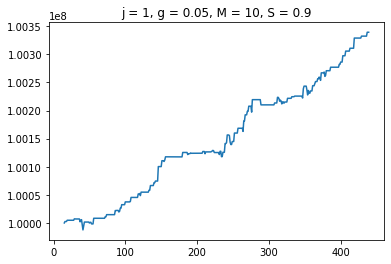

In [4]:
window = 10
S = 0.05
g = 1#np.percentile(data['indicator'],50+params1)
j = 0.9#np.percentile(data['indicator'],50+params2)
data_new = test(window,S,g,j)

In [5]:
#Analysis 
#Sharpe & Sortino
sharpe = data_new['ret'].mean()/data_new['ret'].std()
sortino = data_new['ret'].mean()/data_new['ret'].loc[data_new['ret']<0].std()
print(sharpe)
print(sortino)

0.2139485894762849
0.24339819717697955


In [6]:
#ff3 data
ff = pd.read_csv('C:/Users/Krist/OneDrive/desktop/quant strategies/hw2/F-F_Research_Data_Factors_daily.csv')
ff = ff.rename(columns = {'Unnamed: 0':'Date'})
ff = ff.loc[(ff['Date'] >= '20171204') & (ff['Date'] <= '20190830')]

In [7]:
#merge
daily_return = pd.DataFrame(columns = {'Date', 'ret'})
daily_return['Date'] = data_new['Date']
daily_return['ret'] = data_new['ret']
daily_return['Date'] = daily_return['Date'].apply(lambda x: x[0:4]+x[5:7]+x[8:])

reg = daily_return.merge(ff,how = 'left', on = 'Date')
reg = reg.dropna()
reg['R_spread'] = reg['ret']-reg['RF']

sharpe2 = reg['R_spread'].mean()/reg['R_spread'].std()
sortino2 = reg['R_spread'].mean()/reg['R_spread'].loc[reg['R_spread']<0].std()
print(sharpe2)
print(sortino2)

-5.258015771149507
-5.258015771149507


In [8]:
#regression
factors = ['Mkt-RF','SMB','HML']
for f in factors:
    regression = linear_model.OLS(reg['R_spread'],reg[f])
    result = regression.fit()
    print(result.params)
    print(result.tvalues)
    res = result.resid
    print(res.mean()/res.std())
    print(res.mean()/res.loc[res<0].std())

regression = linear_model.OLS(reg['R_spread'],reg[['Mkt-RF','SMB','HML']])
result = regression.fit()
print(result.params)
print(result.tvalues)
res = result.resid
print(res.mean()/res.std())
print(res.mean()/res.loc[res<0].std())

Mkt-RF   -0.000148
dtype: float64
Mkt-RF   -0.381949
dtype: float64
-5.238325099708412
-5.238325099708412
SMB    0.000757
dtype: float64
SMB    0.982486
dtype: float64
-5.163862478494679
-5.163862478494679
HML    0.00132
dtype: float64
HML    1.926814
dtype: float64
-4.60065242065644
-4.60065242065644
Mkt-RF    0.000056
SMB       0.001020
HML       0.001496
dtype: float64
Mkt-RF    0.137711
SMB       1.309127
HML       2.066063
dtype: float64
-4.450766233708933
-4.450766233708933
